In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## Polar Sea Ice Prediction

In [2]:
# pip install attention

## Initial Setup

In [3]:
import os
import math
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
# import tensorflow.keras
from tensorflow.keras.optimizers import Adam
from attention import Attention
from keras.layers import Dense, Dropout
from keras.layers import LSTM,TimeDistributed
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from numpy.random import seed

import os
import csv

seed_number = 2
seed(seed_number)

## Loading Combined Data 1979- 2018

Features:
'wind_10m', 'specific_humidity', 'LW_down', 'SW_down', 'rainfall', 'snowfall', 'sosaline', 'sst', 't2m', 'surface_pressure','sea_ice_extent'




In [4]:
path = '/content/drive/MyDrive/SYDE 675/Project/Data'
data_path = path + '/monthly_features.npy'
target_path = path + '/monthly_target.npy'

In [5]:
# data = np.load('/.../monthly_features.npy',allow_pickle=True)
# target = np.load('/.../monthly_target.npy',allow_pickle=True)

data = np.load(data_path, allow_pickle=True)
target = np.load(target_path, allow_pickle=True)

### Adding a Lag to Y values
Here lag = 1 month


In [6]:
#Adding a lag to monthly targets
lag = 1
data = data[:-lag,:,:]
target = target[lag:]

print(data.shape)
print(target.shape)


(479, 1, 11)
(479,)


## Train Validation Split

LSTM network expects the input data to be provided with a specific array structure in the form of: [samples, time steps, features]. We load the csv file and only retain the feature and target columns. The features and target are stored in separate np arrays.

In [7]:
# Sequential split train:val data in 80:20 sequentially 

LEN_DATA = len(data) #total number of pixels

NUM_TRAIN = LEN_DATA - (60) #reserve last 30 months for testing
NUM_TEST = LEN_DATA - NUM_TRAIN

print('LEN_DATA:',LEN_DATA)
print('NUM_TRAIN:',NUM_TRAIN)
print('NUM_TEST:',NUM_TEST)

x_train = data[0:NUM_TRAIN]
x_test = data[NUM_TRAIN:]

#split features and labels
y_train = target[:NUM_TRAIN] #target is last column i-e sea-ice
y_test = target[NUM_TRAIN:] #target is last column i-e sea-ice


LEN_DATA: 479
NUM_TRAIN: 419
NUM_TEST: 60


In [8]:
print('x_train.shape:',x_train.shape)
print('y_train.shape:',y_train.shape)
print('x_test.shape:',x_test.shape)
print('y_test.shape:',y_test.shape)

x_train.shape: (419, 1, 11)
y_train.shape: (419,)
x_test.shape: (60, 1, 11)
y_test.shape: (60,)


## Reshaping Input and Target Features

In [9]:
# convert an array of values into a dataset matrix
def reshape_features(dataset, timesteps=1):
    print(dataset.shape)
    X = dataset.reshape((int(dataset.shape[0]/timesteps)), timesteps, dataset.shape[1])
    return X

## Normalization


In [10]:
# normalize the features

scaler_f = StandardScaler()
x_train = scaler_f.fit_transform(x_train.reshape(-1,11)) #reshaping to 2d for standard scaling
x_test = scaler_f.transform(x_test.reshape(-1,11)) #reshaping to 2d for standard scaling

scaler_l = StandardScaler()
y_train = scaler_l.fit_transform(y_train.reshape(-1,1)) #reshaping to 2d for standard scaling
y_test = scaler_l.transform(y_test.reshape(-1,1)) #reshaping to 2d for standard scaling


In [11]:
#Reshaping data to 3D for modeling
timesteps = 1
x_train = reshape_features(x_train, timesteps) # reshaping to 3d for model
x_test = reshape_features(x_test, timesteps) # reshaping to 3d for model


(419, 11)
(60, 11)


In [12]:
print('x_train.shape:',x_train.shape)
print('y_train.shape:',y_train.shape)
print('x_test.shape:',x_test.shape)
print('y_test.shape:',y_test.shape)

x_train.shape: (419, 1, 11)
y_train.shape: (419, 1)
x_test.shape: (60, 1, 11)
y_test.shape: (60, 1)


## LSTM Network

In [13]:
import numpy as np
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import load_model, Model

timestep = timesteps
features = 11

model_input = Input(shape=(timestep,features))
x = LSTM(64, return_sequences=True)(model_input)
x = Dropout(0.2)(x)
x = LSTM(32, return_sequences=True)(x)
x = LSTM(16, return_sequences=True)(x)
x = LSTM(16, return_sequences=True)(x)
x = Attention(trainable = True)(x)
x = Dropout(0.2)(x)
x = Dense(32)(x)
x = Dense(16)(x)
x = Dense(1)(x)
model = Model(model_input, x)
#model.compile(loss='mae', optimizer='adam')
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 11)]           0         
                                                                 
 lstm (LSTM)                 (None, 1, 64)             19456     
                                                                 
 dropout (Dropout)           (None, 1, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 32)             12416     
                                                                 
 lstm_2 (LSTM)               (None, 1, 16)             3136      
                                                                 
 lstm_3 (LSTM)               (None, 1, 16)             2112      
                                                                 
 attention (Attention)       (None, 128)               4352  

In [14]:
extent = target
print(extent.shape)

(479,)


## Compiling the Network and Fitting Model

In [15]:
#Compiling the network
model.compile(loss='mean_squared_error', optimizer='adam')
checkpoint_path='./testmodel.h5'
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=60, mode='min', min_delta=0.001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]


In [16]:
# history=model.fit(x_train, y_train, epochs=500, batch_size=12, verbose=2, validation_split =0.2, shuffle=True,callbacks=keras_callbacks)

# Train on entire dataset (no cross-validation)

In [17]:
history=model.fit(x_train, y_train, epochs=100, batch_size=12, verbose=2, shuffle=True)

Epoch 1/100
35/35 - 16s - loss: 0.7775 - 16s/epoch - 455ms/step
Epoch 2/100
35/35 - 0s - loss: 0.0836 - 341ms/epoch - 10ms/step
Epoch 3/100
35/35 - 0s - loss: 0.0447 - 335ms/epoch - 10ms/step
Epoch 4/100
35/35 - 0s - loss: 0.0399 - 335ms/epoch - 10ms/step
Epoch 5/100
35/35 - 0s - loss: 0.0348 - 324ms/epoch - 9ms/step
Epoch 6/100
35/35 - 0s - loss: 0.0331 - 329ms/epoch - 9ms/step
Epoch 7/100
35/35 - 0s - loss: 0.0310 - 330ms/epoch - 9ms/step
Epoch 8/100
35/35 - 0s - loss: 0.0291 - 338ms/epoch - 10ms/step
Epoch 9/100
35/35 - 0s - loss: 0.0289 - 327ms/epoch - 9ms/step
Epoch 10/100
35/35 - 0s - loss: 0.0282 - 327ms/epoch - 9ms/step
Epoch 11/100
35/35 - 0s - loss: 0.0217 - 326ms/epoch - 9ms/step
Epoch 12/100
35/35 - 0s - loss: 0.0256 - 330ms/epoch - 9ms/step
Epoch 13/100
35/35 - 0s - loss: 0.0208 - 361ms/epoch - 10ms/step
Epoch 14/100
35/35 - 0s - loss: 0.0261 - 328ms/epoch - 9ms/step
Epoch 15/100
35/35 - 0s - loss: 0.0229 - 337ms/epoch - 10ms/step
Epoch 16/100
35/35 - 0s - loss: 0.0240 - 3

## Model Predictions

In [18]:
trainPred = model.predict(x_train)
testPred = model.predict(x_test)

In [19]:
print(testPred.shape)
print(trainPred.shape)

(60, 1)
(419, 1)


In [20]:
#Reverting data back to 2D from 3D
x_test_t = x_test.reshape((x_test.shape[0], x_test.shape[2]))
print(x_test_t.shape)
print(testPred.shape)

(60, 11)
(60, 1)


In [21]:
# invert scaling for forecasted values 

inv_testPred = scaler_l.inverse_transform(testPred)
print(inv_testPred[1])

# invert scaling for actual values

inv_y_test = scaler_l.inverse_transform(y_test)
print(inv_y_test[1])


[15113039.]
[14545530.]


In [22]:
# calculate RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(inv_y_test, inv_testPred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 539491.191


In [23]:
# calculate Normalized RMSE
y_max = inv_y_test.max()
y_min = inv_y_test.min()
nrmse = rmse /(inv_y_test.mean()) 
print('Test NRMSE:', nrmse)

Test NRMSE: 0.050391169178680494


In [24]:
inv_y_test.mean()

10706066.15

In [25]:
# calculate R-square
from sklearn.metrics import r2_score
from math import sqrt

r_sq = r2_score(inv_y_test, inv_testPred)
print('Test R_Square: %.4f' % r_sq)

Test R_Square: 0.9730


# Write scores in csv files

In [26]:
file_path = '/content/drive/MyDrive/SYDE 675/Project/Models/m-LSTM/scores.csv'

header = ['seed', 'Test RMSE', 'Test normalized RMSE', 'R_Square']

if os.path.exists(file_path):
  # If file exists, append row
  with open(file_path, 'a', encoding='UTF8') as f:
    writer = csv.writer(f)

    # write the data
    writer.writerow([seed_number, rmse, nrmse, r_sq])

else:
  # If file does not exist, write new file
  with open(file_path, 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write the data
    writer.writerow([seed_number, rmse, nrmse, r_sq])

In [30]:
results = pd.read_csv(file_path)
results.describe()

,seed,Test RMSE,Test normalized RMSE,R_Sqaure
count,20.000000,20.000000,20.000000,20.000000
mean,1.500000,520110.276895,0.048581,0.974357
std,0.512989,76546.673118,0.007150,0.007559
min,1.000000,383787.426834,0.035848,0.956892
25%,1.000000,472168.570009,0.044103,0.969819
50%,1.500000,518171.581996,0.048400,0.975060
75%,2.000000,570003.186974,0.053241,0.979293
max,2.000000,681263.873887,0.063633,0.986319


## Plotting

KeyError: ignored

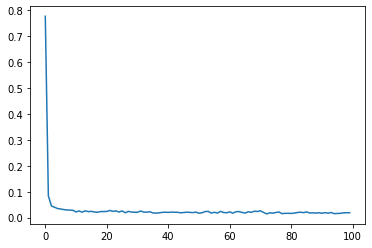

In [27]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_train,trainPred)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('observed')
ax.set_ylabel('predicted')
plt.show()


In [ ]:
fig, ax = plt.subplots()
ax.scatter(inv_y_valid,inv_testPred) #[:,:,6]
ax.plot([inv_y_valid.min(), inv_y_valid.max()], [inv_y_valid.min(), inv_y_valid.max()], 'k--', lw=4)
ax.set_xlabel('observed')
ax.set_ylabel('predicted')
#plt.savefig('test_prediction.png',bbox_inches='tight',dpi=1200)
plt.show()

In [ ]:
trainPred = np.transpose(trainPred.flatten())

print(trainPred.shape)
print(y_train.shape)

In [ ]:
from matplotlib import pyplot

pyplot.plot(trainPred)
pyplot.plot(y_train)
pyplot.show()

In [ ]:
from matplotlib import pyplot
fig, ax= plt.subplots(figsize=(24, 8))
pyplot.plot(inv_testPred)
pyplot.plot(inv_y_valid)
pyplot.show()